In [2]:
# for dealing with data
import pandas as pd
import numpy as np

#for visualization
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as st
import random


#machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import PredefinedSplit

#for mathematics and statistics
import math
from scipy import stats
import scipy as sci
from scipy.spatial.distance import minkowski
from scipy.stats import spearmanr

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [4]:
# we import the dataset using pandas
pddata = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip', error_bad_lines=False, skiprows=1)

In [5]:
# we visualize the first ten rows of our dataframe
pddata = pddata.to_numpy()
RelKa = pddata[:, -1]
training_data = pddata[:, 2:-1]

In [23]:
from sklearn.ensemble import IsolationForest

def split_outliers(threshold, scores):
  outliers_indices = np.where(scores < threshold)[0]
  return outliers_indices

def Anomaly_Detection_Isolation_Forests(x, change_split=False):
  random_state = np.random.RandomState(42)
  contamination = 'auto'
  threshold = np.random.uniform(-0.03, -0.02, 1)
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  if change_split == False:
    anomaly_score = model.predict(x)
    outliers_indices = np.where(anomaly_score == -1)[0]
  if change_split == True:
    outliers_indices = split_outliers(threshold, scores)
  return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  if contamination != 'auto':
    outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(RelKa) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)
    print("The percentage of outliers detected is", 1 / len(scores) * len(np.where(scores < 0)[0]))

def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

In [7]:
def split_importance(x, y, importance_class=0.7):
  """
  Split the samples into interesting ones and not interesting ones
  :param x: numpy.ndarray:the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param importance_class: float: the lower bound for the underepresented class
  """
  return x[y >= importance_class], y[y >= importance_class], x[y < importance_class], y[y < importance_class]

In [24]:
x_1, y_1, x_0, y_0 = split_importance(training_data, RelKa)

In [25]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set and in the train set
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.3, random_state=42)
x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, test_size=0.3, random_state=42)

x_train = np.concatenate((x_1_train, x_0_train))
y_train = np.concatenate((y_1_train, y_0_train))
x_test = np.concatenate((x_1_test, x_0_test))
y_test = np.concatenate((y_1_test, y_0_test))

In [26]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [11]:
def random_undersampling(x, y, alpha, importance_boundary=0.7):
  """
  alpha is a parameter bigger than 1/2
  """
  count = 0
  to_drop = []
  for i in range(x.shape[0]):
    print("Checking the ", i, "sample")
    U = st.uniform.rvs(size=1)
    if y[i] <= importance_boundary:
      if U <= alpha:
        to_drop.append(i)
  x = np.delete(x, to_drop, axis=0)
  y = np.delete(y, to_drop, axis=0)
  return x, y

In [12]:
def stratified_undersampling(x, y, intervals = 0.05 * np.arange(0, 15)):
  """
  This function performs stratified undersampling on the majority class
  by dropping samples in each strata with a probability equal to the frequency
  :param x: the datapoints to be undersampled
  :param y: the corresponding labels
  :param alpha: a hyperparameter to choose the dropping probability 
  :param intervals: the stratification intervals
  :return x and y undersampled  
  """
  # just a check that we drop with high probability in the frequent strata
  to_drop = []
  # we do a cycle over all intervals
  for i in range(len(intervals)-1):
    # get the indices for which the label is in the i-th strata
    indices = np.where(np.logical_and(intervals[i] < y, y < intervals[i+1]))[0]
    # compute the frequency of the i-th strata
    frequency = len(indices) / len(y)
    # we do a cycle over all elements in such a stratum
    for j in range(len(indices)):
      # we draw a uniform random variable
      U = st.uniform.rvs(size=1)
      if U <= frequency:
        # we drop every sample in the i-th strata with probability alpha * frequency
        to_drop.append(indices[j])
  # we drop from x and y the samples and the labels found before
  x_new = np.delete(x, to_drop, axis=0)
  y_new = np.delete(y, to_drop, axis=0)
  return x_new, y_new

In [13]:
#quantization function required for some score functions
def quantize(x,cuts=100):
  ranges = np.sort(np.unique(pd.cut(x,cuts)))
  for i in range(ranges.shape[0]):
    ranges_i = ranges[i]
    x[(x<=ranges_i.right)&(x>ranges_i.left)] = (ranges_i.left +ranges_i.right)/2
  return x

def quantize_features(x,cuts=100):
  return np.apply_along_axis(quantize,0,x,cuts)

#correlation scorers
def Spearman(i,j):
  ret,_ = spearmanr(i,j)
  return ret

def Correlation_Score(x,y):
  x = x.T
  score = [min([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)

def Correlation_Score_Max(x,y):
  x = x.T
  score = [-max([abs(Spearman(j,i)) for i in x]) for j in x]
  return np.array(score)

def Closest(x, z):
    """
    Returns the index of the sample in x which is the closest one to all the samples in z
    :param x: numpy.ndarray: The array of the samples for which we seek to find the furthest
    :param z: numpy.ndarray: The array of the samples which we use as a point of reference
    :return: int: returns a single index corresponding to the furthest x
    """
    distances = []
    # we seek for the closest point to z in x
    for i in range(x.shape[0]):
        # for each sample in x we calculate the distance from all points in z and we take the minimum
        distance = min([np.linalg.norm(j - x[i]) for j in z])
        # we add the calculated distance to the list
        distances.append(distance)
    # we return the closest point by taking the argmin over all calculated distances
    return np.argmin(distances)

In [14]:
def PSU_undersampling_regression(x, y, randomsize, xi, yi):
    """
    This function performs the PSU undersampling of the samples in the x,y arrays
    with regards to the set xi,yi. This version is a slight modification of the original proposed algorithm
    which helps us improving in the prediction of the RelKa in the central intervals
    :param x: numpy.ndarray: The array of samples on which we perform the undersampling
    :param y: numpy.ndarray: The labels corresponding to the samples in x
    :param randomsize: int: An integer corresponding to the number of samples to be left
    :param xi: numpy.ndarray: The array with the samples to be used as a reference for distances
    :param yi: numpy.ndarray: The labels of the samples in xi
    :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
    """
    # we calculate the centroid of the majority class data
    C = np.mean(x, axis=0)
    # for each sample in the majority class we calculate the l2 distance from the centroid
    dist = np.linalg.norm(x - C, 2, axis=1)
    # we sort the distances
    indices = dist.argsort()
    # we sort the samples and the corresponding labels according to the distances calculated before
    x = x[indices]
    y = y[indices]
    # we split the samples and the corresponding labels in randomsize partitions
    split_x = np.array_split(x, randomsize)
    split_y = np.array_split(y, randomsize)
    # for each partition we calculate the closest point to the minority class xi
    indices = [Closest(split_x[i], xi) for i in range(randomsize)]
    # the collection of the randomsize closest points calculated above represents the undersampled data
    x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
    # the corresponding labels of the undersampled data are also returned
    y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
    return x_resample, y_resample

In [15]:
def PSU_stratified_undersampling(x, y, randomsize, intervals, xi, yi):
    """
    This function performs the PSU undersampling of the samples in the x,y arrays
    with regards to the set xi,yi. This version is a slight modification of the original proposed algorithm
    which helps us improving in the prediction of the RelKa in the central intervals
    :param x: numpy.ndarray: The array of samples on which we perform the undersampling
    :param y: numpy.ndarray: The labels corresponding to the samples in x
    :param randomsize: int: An integer corresponding to the number of samples to be left
    :param intervals: the intervals for stratification
    :param xi: the reference points
    :param yi: the corresponding labels to xi
    :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
    """
    # we calculate the number of strata
    k = intervals.shape[0]
    print(k)
    # we initialize the lists for undersampling
    x_resample = np.zeros(x.shape[1])
    x_resample = x_resample[..., np.newaxis].T
    y_resample = []
    for i in range(len(intervals)-1):
        indices = np.where(np.logical_and(intervals[i] < y, y < intervals[i+1]))[0]
        # we get the samples and the labels in the i-th strata
        x_ = x[indices]
        y_ = y[indices]
        frequency = len(indices) / len(y)
        # we perform the modified PSU undersampling on the i-th strata
        x_, y_ = PSU_undersampling_regression(x_, y_, int(randomsize*frequency), xi, yi)
        # we add the samples and the corresponding labels
        x_resample = np.concatenate([x_resample, x_], axis=0)
        y_resample = np.concatenate([y_resample, y_], axis=0)
    # we drop the first row used only for initialization
    x_resample = np.delete(x_resample, 0, axis=0)
    return x_resample, y_resample

In [16]:
def Furthest(x, z):
    """
    Returns the index of the sample in x which is furthest from all the samples in z
    :param x: numpy.ndarray: The array of the samples for which we seek to find the furthest
    :param z: numpy.ndarray: The array of the samples which we use as a point of reference
    :return: int: returns a single index corresponding to the furthest x
    """
    # we initialize the maximum distance to be -1 and the furthest sample to have index 0
    max_dist_i = 0
    max_dist = -1
    # we seek for the furthest point from z in x
    for i in range(x.shape[0]):
        # for each sample in x we calculate the distance from all points in z and we take the minimum
        distance = min([np.linalg.norm(j - x[i]) for j in z])
        # we update the distance if the current distance is larger than the old one
        if max_dist < distance:
            max_dist = distance
            # we save the current sample i as the candidate furthest point from z
            max_dist_i = i
    return max_dist_i

def PSU_undersampling(x,y,randomsize,xi,yi):
  """
  This function calculates the PSU undersampling of the samples in the x,y arrays
  with regards to the set xi,yi
  :param x: numpy.ndarray: The array of samples, which we want to undersample
  :param y: numpy.ndarray: The array with the labels corresponding to the samples in x
  :param randomsize: int: An int corresponding to the number of samples to be left
  :param xi: numpy.ndarray: The array with the samples to be used as a reference for distances
  :param yi: numpy.ndarray: The labels of these samples
  :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
  """
  C = np.mean(x,axis = 0)
  dist = np.linalg.norm(x-C,2,axis = 1)
  indices = dist.argsort()
  x = x[indices]
  y = y[indices]
  split_x = np.array_split(x,randomsize)
  split_y = np.array_split(y,randomsize)
  indices = [Furthest(split_x[i],xi) for i in range(randomsize)]
  x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
  y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
  return x_resample, y_resample

def PSU_undersampling_reduced_dim(x,y,randomsize,xi,yi):
  """
  This function calculates the PSU undersampling by first doing a dimensionality reduction
  of the samples in the x,y arrays with regards to the set xi,yi
  :param x: numpy.ndarray: The array of samples, which we want to undersample
  :param y: numpy.ndarray: The array with the labels corresponding to the samples in x
  :param randomsize: int: An int corresponding to the number of samples to be left
  :param xi: numpy.ndarray: The array with the samples to be used as a reference for distances
  :param yi: numpy.ndarray: The labels of these samples
  :return: numpy.ndarray,numpy.ndarray: Returns 2 numpy arrays corresponding to the undersampled data
  """
  feature_scores =  Fisher_Score(xi,x)
  indices = np.sort((-feature_scores).argsort()[:10])
  x_filtered = x[:,indices]
  x_i = xi[:,indices]
  C = np.mean(x_filtered,axis = 0)
  dist = np.linalg.norm(x_filtered-C,2,axis = 1)
  indices = dist.argsort()
  x_filtered = x_filtered[indices]
  y = y[indices]
  split_x = np.array_split(x_filtered,randomsize)
  split_y = np.array_split(y,randomsize)
  indices = [Furthest(split_x[i],x_i) for i in range(randomsize)]
  split_x = np.array_split(x,randomsize)
  x_resample = np.array([split_x[i][indices[i]] for i in range(randomsize)])
  y_resample = np.array([split_y[i][indices[i]] for i in range(randomsize)])
  return x_resample, y_resample

In [17]:
def Fisher_Score(x_import, x_nimport):
  """
  Given two arrays of two classes this function calculates the Fischer_scores to 
  measure the significance for all features
  :param x_import: numpy.ndarray: the array containing the samples of one class
  :param x_nimport: numpy.ndarray: the array containing the samples of the other class
  :return: numpy.ndarray: returns an array containg the Fisher_Score for all features 
  """
  mean_import = np.mean(x_import, axis = 0)
  mean_nimport = np.mean(x_nimport, axis = 0)
  mean_dist = np.absolute(mean_import - mean_nimport)
  std_import = np.std(x_import, axis=0)
  std_nimport = np.std(x_nimport, axis=0)
  std_sum = std_import+std_nimport
  #return std_sum
  return np.divide(mean_dist,std_sum)

def calculate_distances(x, distance):
  """
  Calculates the distance between any two pairs of the set x using 
  the Minkowski distance of degree distance.
  :param x: numpy.ndarray: the vector for which we will calculate the distance 
                            between all of its elements 
  :param distance: float: the norm which should be used for the Minkowski distance
  :return: numpy.ndarray: returns the Minkowski distance with the specified norm 
                          between all pairs of elements in x 
  """
  dist = np.array([[minkowski(a1,a2,distance) for a2 in x] for a1 in x])
  np.fill_diagonal(dist,float('inf'))
  return dist

def random_sampler(x, y, randomsize):
  """
  This function does random undersampling of vectors x,y and reduces them to 
  size random size
  :param x: numpy.ndarray: the feature vector to be subsampled
  :param y: numpy.ndarray: the label vector to be subsampled
  :return: <class 'tuple'>: A tuple containing the two undersampled vectors
  """
  p = np.random.permutation(len(y))
  new_x = x[p]
  new_y = y[p]
  return new_x[:randomsize],new_y[:randomsize]

def generate_samples(x, y, neighbors, N):
  """
  This function generate N samples which are convex combinations of 
  the features of x and the labels of y
  :param x: numpy.ndarray:
  :param y: numpy.ndarray:
  :return: <class 'tuple'>:
  """
  new_samples_x = []
  new_samples_y = []
  for i in range(N):
    random_sample_i = random.randint(0,y.shape[0]-1)
    x_i = x[random_sample_i]
    random_sample_j = random.randint(0,neighbors.shape[1]-1)
    neigh_i = neighbors[random_sample_i,random_sample_j]
    x_j = x[neigh_i]
    lambda_ = random.uniform(0,1)
    y_i = y[random_sample_i]
    y_j = y[neigh_i]
    new_x = x_i + lambda_*(x_j-x_i)
    new_y = y_i + lambda_*(y_j-y_i)
    new_samples_x.append(new_x)
    new_samples_y.append(new_y)
  return np.array(new_samples_x),np.array(new_samples_y)

def random_sampler(x,y,randomsize):
  """
  This function does random undersampling of vectors x,y and reduces them to 
  size random size
  :param x: numpy.ndarray: the feature vector to be subsampled
  :param y: numpy.ndarray: the label vector to be subsampled
  :return: <class 'tuple'>: A tuple containing the two undersampled vectors
  """
  p = np.random.permutation(len(y))
  new_x = x[p]
  new_y = y[p]
  return new_x[:randomsize],new_y[:randomsize]

def generate_samples(x,y,neighbors,N):
  """
  This function generate N samples which are convex combinations of 
  the features of x and the labels of y
  :param x: numpy.ndarray:
  :param y: numpy.ndarray:
  :return: <class 'tuple'>:
  """
  new_samples_x = []
  new_samples_y = []
  for i in range(N):
    random_sample_i = random.randint(0,y.shape[0]-1)
    x_i = x[random_sample_i]
    random_sample_j = random.randint(0,neighbors.shape[1]-1)
    neigh_i = neighbors[random_sample_i,random_sample_j]
    x_j = x[neigh_i]
    lambda_ = random.uniform(0,1)
    y_i = y[random_sample_i]
    y_j = y[neigh_i]
    new_x = x_i + lambda_*(x_j-x_i)
    new_y = y_i + lambda_*(y_j-y_i)
    new_samples_x.append(new_x)
    new_samples_y.append(new_y)
  return np.array(new_samples_x),np.array(new_samples_y)

def smote_sf_classification(x, y, undersample=0.1, oversample=0.3, attribute_scorer=Fisher_Score,
                            attribute_number=10, distance=float('inf'), kneighbors=3, importance_class=0.7):
    """
    This function takes the complete input and produces a more balanced dataset based on the importance class
    :param x: numpy.ndarray: the feature vector of the initial dataset
    :param y: numpy.ndarray: the value vector of the initial dataset
    :param undersample: float: the percentage of the dominant class that we want to keep
    :param oversample: float: the percentage of the dataset that the minority class will be at the end
    :param attribute_scorer: function: a function which will be used to score the relevance of a feature
    :param attribute_number: int: the number of attributes to keep according to their score
    :param distance: float: the norm which should be used for the Minkowski distance
    :param kneighbors: int: the number of nearest neighbours to be considered for each point
    :param importance_class: float: the lower bound for the under-represented class
    :return: returns 2 new feature vectors and 2 new label vectors containing
            the data for the importance class and the data for the non importance
            class and their labels.
    """
    # we split the training set into majority and minority class according to the value of the label
    x_import = x[y >= importance_class]
    y_import = y[y >= importance_class]
    x_nimport = x[y < importance_class]
    y_nimport = y[y < importance_class]

    # we calculate the Fisher score for all the features
    feature_scores = attribute_scorer(x_import, x_nimport)
    # we find the attribute_number highest coordinates of the feature_scores vector
    indices = np.sort((-feature_scores).argsort()[:attribute_number])
    # we filter the samples to be represented only by the attribute number highest scored features
    x_import_filtered = x_import[:, indices]
    # we calculate the distances between the datapoints considering only the important features as otherwise we
    # fall into the curse of dimensionality
    distances = calculate_distances(x_import_filtered, distance)
    # we find the kneighbors lowest indices of the distances of each sample, the corresponding datapoints are the
    # nearest neighbours to be drawn randomly for the oversampling procedure
    neighbors = np.array([np.sort(d.argsort()[:kneighbors]) for d in distances])
    # we first undersample the the majority class
    # we calculate the final size of the undersampled data
    nimport_len = int(undersample * y_nimport.shape[0])
    # we perform undersampling
    x_nimport, y_nimport = PSU_undersampling(x_nimport, y_nimport, nimport_len, x_import, y_import)
    # we calculate the number of samples to be generated by the oversampling algorithm
    N = int(oversample * (y_nimport.shape[0]) - y_import.shape[0])
    # we perform oversampling
    new_samples_x, new_samples_y = generate_samples(x_import, y_import, neighbors, N)
    # we merge the new samples with the old samples of the minority class and their labels
    x_import = np.concatenate((x_import, new_samples_x))
    y_import = np.concatenate((y_import, new_samples_y))
    # we stack the samples and the labels of the majority and minority class
    x_ret = np.concatenate((x_import, x_nimport))
    y_ret = np.concatenate((y_import, y_nimport))
    # x_ret represents the balanced dataset and y_ret the corresponding labels
    return x_ret, y_ret

In [18]:
def smote_sf_regression(x, y, undersample=0.1, oversample=0.3, attribute_scorer=Fisher_Score,
                        attribute_number=10, distance=float('inf'), kneighbors=3,
                        importance_class=0.7, width_strata=0.1):
    """
    This function performs stratified undersampling and SMOTE oversampling for the regression task
    @param x: the initial dataset
    @param y: the corresponding labels
    @param undersample: the undersampling rate
    @param oversample: the oversampling rate
    @param attribute_scorer: the scorer for the features
    @param attribute_number: the number of features to be considered for the distances between samples
    @param distance: the degree of the Minkowski distance to be used
    @param kneighbors: the number of nearest neighbours for the oversampling algorithm
    @param importance_class: the importance boundary between majority and minority class
    @param width_strata: the width of the strata for the stratified undersampling
    @return: x and y rebalanced
    """
    # we split the training set into majority and minority class according to the value of the label
    x_import = x[y >= importance_class]
    y_import = y[y >= importance_class]
    x_nimport = x[y < importance_class]
    y_nimport = y[y < importance_class]

    # we calculate the Fisher score for all the features
    feature_scores = attribute_scorer(x_import, x_nimport)
    # we find the attribute_number highest coordinates of the feature_scores vector
    indices = np.sort((-feature_scores).argsort()[:attribute_number])
    # we filter the samples to be represented only by the attribute number highest scored features
    x_import_filtered = x_import[:, indices]
    # we calculate the distances between the datapoints considering only the important features as otherwise we
    # fall into the curse of dimensionality
    distances = calculate_distances(x_import_filtered, distance)
    # we find the kneighbors lowest indices of the distances of each sample, the corresponding datapoints are the
    # nearest neighbours to be drawn randomly for the oversampling procedure
    neighbors = np.array([np.sort(d.argsort()[:kneighbors]) for d in distances])
    # we get the undersampled datasize
    nimport_len = int(undersample * y_nimport.shape[0])
    print(nimport_len)
    # we perform stratified undersampling
    intervals = width_strata * np.arange(int(importance_class / width_strata))
    print(intervals)
    x_nimport, y_nimport = stratified_undersampling(x_nimport, y_nimport, intervals)
    # we compute the number of new samples to be generated
    N = int(oversample * (y_nimport.shape[0]) - y_import.shape[0])
    new_samples_x, new_samples_y = generate_samples(x_import, y_import, neighbors, N)
    # we merge the new samples with the old samples of the minority class and their labels
    x_import = np.concatenate((x_import, new_samples_x))
    y_import = np.concatenate((y_import, new_samples_y))
    # we stack the samples and the labels of the majority and minority class
    x_ret = np.concatenate((x_import, x_nimport))
    y_ret = np.concatenate((y_import, y_nimport))
    # x_ret represents the balanced dataset and y_ret the corresponding labels
    return x_ret, y_ret

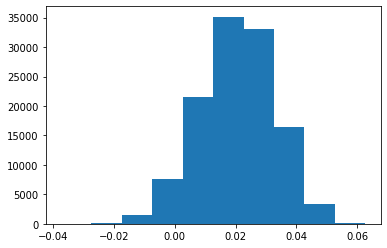

The indecision percentage around 0.02 is 0.3294876304373314
The percentage of outliers detected is 0.05331435032033834


In [27]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x_train, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [28]:
x_train, y_train = drop_outliers(x_train, y_train, outliers_indices)

In [29]:
x_train, y_train = smote_sf_regression(x_train, y_train)

11281
[0.  0.1 0.2 0.3 0.4 0.5]


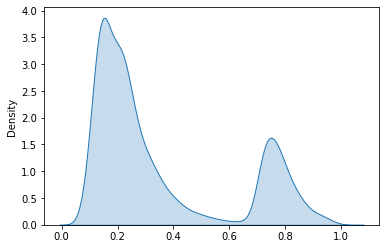

In [30]:
sns.kdeplot(y_train, fill=True)

In [31]:
# we use XGB regressor model with the following hyperparameters

model = XGBRegressor(subsample = 0.8999999999999999, n_estimators= 500,
                     max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.6, obj=MSE)
model.fit(x_train, y_train,eval_metric=MSE)
predictions = model.predict(x_test)

[18:16:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


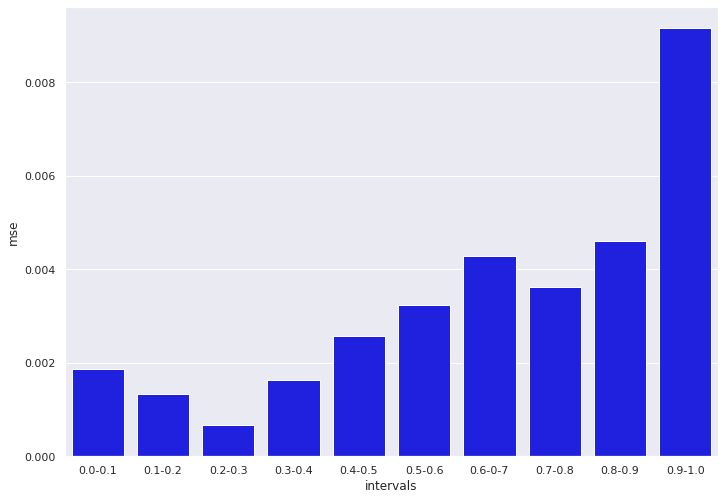

In [32]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()